<a href="https://colab.research.google.com/github/Sumanth-Amballa/CECS_550_SY_Proj/blob/main/FDRIncep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This code is used to mount Google Drive to Colab Environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Unzip the zip file from Google Drive
!unzip -q "/content/drive/My Drive/archive.zip" -d "/content/inceptionv3retinadataset"


In [ ]:
# Importing libraries for data handling, machine learning model building, training, and visualization.
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [ ]:
# Define the path to the dataset
data_path = '/content/inceptionv3retinadataset/colored_images/'


In [ ]:
!ls "/content/inceptionv3retinadataset"

colored_images	train.csv


In [ ]:
# function to preprocess images by adjusting image data types and applying model preprocessing
from tensorflow.keras.applications.inception_v3 import preprocess_input
def preprocess_image(img):
    img = np.array(img, dtype=np.float32)
    img = preprocess_input(img)  # Preprocessing for InceptionV3
    return img


In [ ]:
# Set up the image data generators for training, validation, and testing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.25  # Using this for creating training and validation splits
)

In [ ]:
# Set up the image data generators for training, validation, and testing
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

In [ ]:
# Setup data generators using the directory structure
train_generator = train_datagen.flow_from_directory(
    directory=data_path,
    target_size=(299, 299),  # InceptionV3 input shape
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Using subset for splitting training data
)


Found 2749 images belonging to 5 classes.


In [ ]:
validation_generator = train_datagen.flow_from_directory(
    directory=data_path,
    target_size=(299, 299),  # InceptionV3 input shape
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Using subset for splitting validation data
)

Found 913 images belonging to 5 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory=data_path,
    target_size=(299, 299),  # InceptionV3 input shape
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for test set to not shuffle for evaluation purposes
)

Found 3662 images belonging to 5 classes.


In [ ]:
# Building the model using InceptionV3 as the base
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
# Initialize and compile the model with Adam optimizer and categorical crossentropy loss, tracking accuracy as a metric
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

In [ ]:
# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # Increase number of epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Adding ReduceLROnPlateau callback
)

Epoch 1/10
86/86 [==============================] - 73s 851ms/step - loss: 0.1580 - accuracy: 0.9422 - val_loss: 0.7066 - val_accuracy: 0.8094 - lr: 1.0000e-04
Epoch 2/10
86/86 [==============================] - 72s 842ms/step - loss: 0.1404 - accuracy: 0.9469 - val_loss: 0.9766 - val_accuracy: 0.7393 - lr: 1.0000e-04
Epoch 3/10
86/86 [==============================] - 72s 836ms/step - loss: 0.1227 - accuracy: 0.9563 - val_loss: 0.9503 - val_accuracy: 0.8083 - lr: 1.0000e-04
Epoch 4/10
86/86 [==============================] - 72s 835ms/step - loss: 0.1070 - accuracy: 0.9593 - val_loss: 0.7783 - val_accuracy: 0.8138 - lr: 1.0000e-04
Epoch 5/10
86/86 [==============================] - 72s 838ms/step - loss: 0.1134 - accuracy: 0.9574 - val_loss: 0.8630 - val_accuracy: 0.7897 - lr: 1.0000e-04
Epoch 6/10
86/86 [==============================] - 73s 846ms/step - loss: 0.1019 - accuracy: 0.9625 - val_loss: 0.9408 - val_accuracy: 0.8018 - lr: 1.0000e-04
Epoch 7/10
86/86 [======================

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

115/115 [==============================] - 13s 115ms/step - loss: 0.2631 - accuracy: 0.9364
Test Accuracy: 93.64%


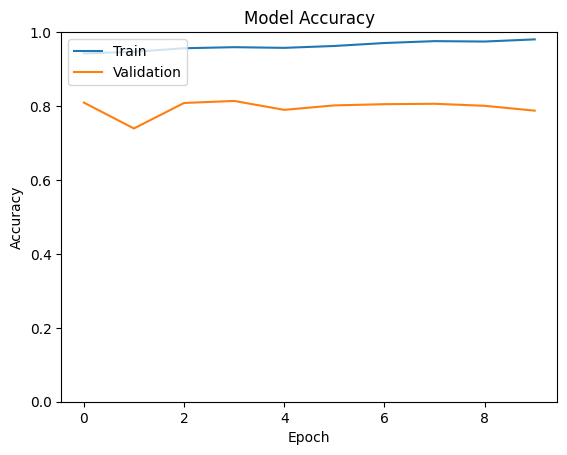

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


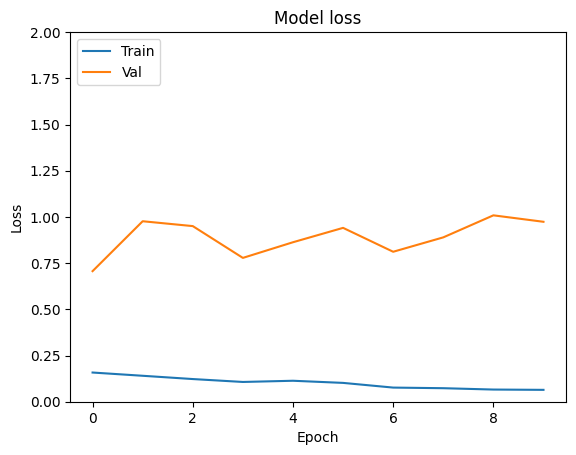

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 2)
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns

# Predictions for confusion matrix
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

115/115 [==============================] - 12s 107ms/step
                precision    recall  f1-score   support

          Mild       0.88      0.85      0.87       370
      Moderate       0.94      0.90      0.92       999
         No_DR       0.98      0.99      0.99      1805
Proliferate_DR       0.84      0.89      0.87       295
        Severe       0.77      0.83      0.80       193

      accuracy                           0.94      3662
     macro avg       0.88      0.89      0.89      3662
  weighted avg       0.94      0.94      0.94      3662



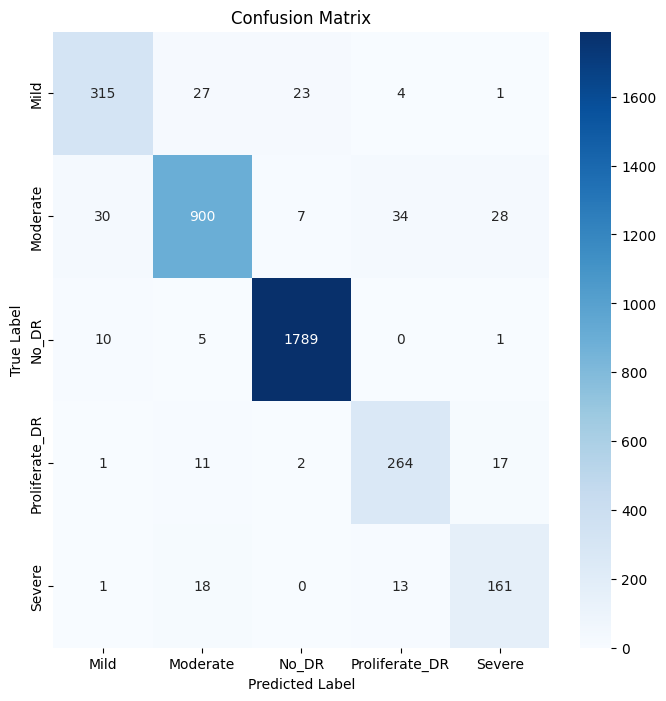

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print("F1 Score: {:.2f}".format(f1))

F1 Score: 0.94
